In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
import toml
config = toml.load('../../../../configuration/input_configuration.toml')
%matplotlib inline

# os.chdir('..\..\..\..')

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [14]:
working_dir = r'../../../../outputs/agg/dash'
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

In [15]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [16]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../../inputs/db/'+config['db_name'],
        columns=['CountyName','ParcelID'])

# Usual Work Distance

In [17]:
person = pd.read_csv(r'../../../../outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'../../../../inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [18]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pwpcl', right_on='ParcelID', how='left')

In [19]:
person['wt_pwautime'] = person['pwautime']*person['psexpfac']
person['wt_pwaudist'] = person['pwaudist']*person['psexpfac']

Average Distance for **All Workers** Not Working at Home (weighted for survey)

In [20]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    10.49
survey   11.55
dtype: float64

Average Distance by Work County

In [21]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,11.31,12.10
Kitsap,9.52,8.23
Pierce,9.07,10.90
Snohomish,8.70,10.99


Average for **Full-Time** Workers only

In [22]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    12.10
survey   12.75
dtype: float64

In [23]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.83,13.23
Kitsap,11.08,9.46
Pierce,10.61,12.21
Snohomish,10.54,12.21


Average for **Part-Time** Workers Only

In [24]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    12.10
survey   12.75
dtype: float64

In [25]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.83,13.23
Kitsap,11.08,9.46
Pierce,10.61,12.21
Snohomish,10.54,12.21


## Trip Length Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Workers

<AxesSubplot:xlabel='pwaudist_bin'>

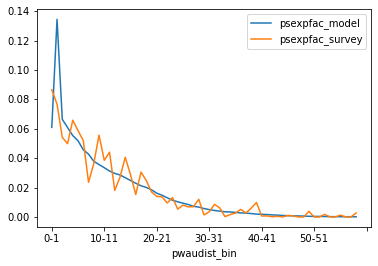

In [26]:
# Create bins
max_bin = 60
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

<AxesSubplot:xlabel='pwaudist_bin'>

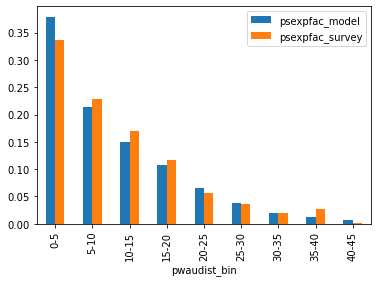

In [27]:
# Create bins
max_bin = 50
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

### Percent of Workers with <1 Mile and >20 Mile Commutes

In [28]:
pd.options.display.float_format = '{:,.1%}'.format

_df_tot = person[person['pwaudist'] > 0].groupby('source').sum()[['psexpfac']].T

_df_1 = person[(person['pwaudist'] < 1) & (person['pwaudist'] > 0)].groupby('source').sum()[['psexpfac']].T
_df_1 = _df_1/_df_tot
_df_1.index = ['< 1 mile']

_df_20 = person[(person['pwaudist'] > 20)].groupby('source').sum()[['psexpfac']].T
_df_20 = _df_20/_df_tot
_df_20.index = ['> 20 miles']

_df = _df_1.append(_df_20).reset_index()
_df.rename(columns={'index': 'Commute Range'}, inplace=True)
_df = _df.rename_axis(None, axis=1)
_df

,Commute Range,model,survey
0,< 1 mile,6.1%,8.6%
1,> 20 miles,15.2%,15.8%


<AxesSubplot:xlabel='Commute Range'>

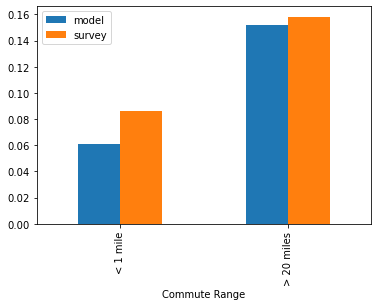

In [29]:
_df.set_index('Commute Range').plot(kind='bar',)

### Average Commute Distance by Gender

In [30]:
pd.options.display.float_format = '{:0,.2f}'.format
df = person[(person['pwaudist'] > 0) & (person['pgend'].isin([1,2]))]
_df = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df['pgend'] = df['pgend'].map({1: 'Male',2:'Female'})
df.rename(columns={'pgend': 'Gender'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Gender,model,survey
0,Male,11.58,12.73
1,Female,9.16,10.04


<AxesSubplot:xlabel='Gender'>

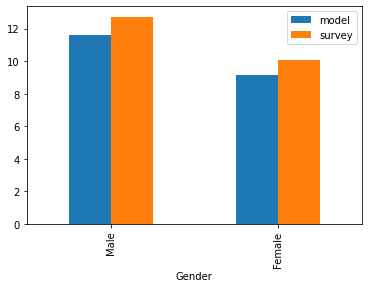

In [31]:
df.set_index('Gender').plot(kind='bar')

### Average Commute Distance by Age

In [32]:
person['age_cat'] = pd.cut(person['pagey'], bins=[0,30,50,64,100], labels=['<29','30-49','50-65','65+'])
df = person[(person['pwaudist'] > 0)]
_df = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df.rename(columns={'age_cat': 'Age Category'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Age Category,model,survey
0,<29,9.34,10.13
1,30-49,10.94,12.27
2,50-65,11.34,11.81
3,65+,8.55,11.78


<AxesSubplot:xlabel='Age Category'>

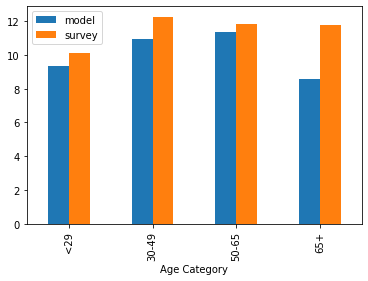

In [33]:
df.set_index('Age Category').plot(kind='bar')

## County to County Work Flows

All Workers

Model Results 

In [34]:
df = load_data(r'work_flows')
pd.options.display.float_format = '{:0,.0f}'.format
df.rename(columns={'person_county': 'Home County', 'person_work_county':'Work County'}, inplace=True)

df_model = pd.pivot_table(df[df['source'] == 'model'], index='Home County', columns='Work County', aggfunc='sum')
df_model['Total'] = df_model.sum(axis=1)
df_model.loc['Total',:] = df_model.sum(axis=0)
df_model

psexpfac                               Total
Work County      King  Kitsap  Pierce Snohomish          
Home County                                              
King        1,175,294     921  43,342    39,232 1,258,789
Kitsap          5,123 109,548   4,756        46   119,473
Pierce         98,717   9,880 298,049       593   407,239
Snohomish     149,929      79     766   277,859   428,633
Total       1,429,063 120,428 346,913   317,730 2,214,134

Survey Results

In [35]:
df_survey = pd.pivot_table(df[df['source'] == 'survey'], index='Home County', columns='Work County', aggfunc='sum')
df_survey['Total'] = df_survey.sum(axis=1)
df_survey.loc['Total',:] = df_survey.sum(axis=0)
df_survey

psexpfac                               Total
Work County      King  Kitsap  Pierce Snohomish          
Home County                                              
King        1,040,916     176  16,124    42,936 1,100,153
Kitsap          7,765 101,665   2,865       NaN   112,295
Pierce         83,508   2,882 280,583       223   367,195
Snohomish      86,485     NaN     NaN   232,820   319,305
Total       1,218,674 104,723 299,572   275,979 1,898,948

Total Difference (Model - Survey)

In [36]:
df_model-df_survey

psexpfac                           Total
Work County     King Kitsap Pierce Snohomish        
Home County                                         
King         134,378    745 27,218    -3,704 158,636
Kitsap        -2,642  7,883  1,891       NaN   7,178
Pierce        15,209  6,998 17,466       370  40,044
Snohomish     63,444    NaN    NaN    45,039 109,328
Total        210,389 15,705 47,341    41,751 315,186

Percent Difference (Relative to Survey)

In [37]:
((df_model-df_survey)/df_survey).applymap(format_percent)

psexpfac                               Total
Work County     King   Kitsap   Pierce Snohomish        
Home County                                             
King          12.91%  423.49%  168.80%    -8.63%  14.42%
Kitsap       -34.03%    7.75%   66.01%      nan%   6.39%
Pierce        18.21%  242.76%    6.23%   166.24%  10.91%
Snohomish     73.36%     nan%     nan%    19.34%  34.24%
Total         17.26%   15.00%   15.80%    15.13%  16.60%